In [89]:
# import sys
# !{sys.executable} -m pip install matplotlib scikit-image numpy


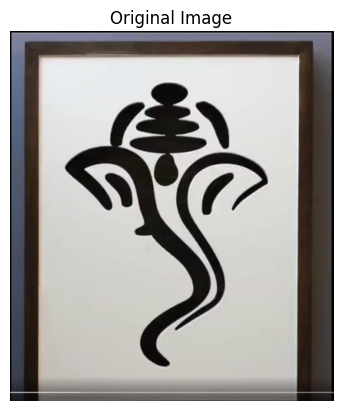

In [ ]:
from skimage import io, color, feature
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter,line_aa
from skimage.io import imread
from math import atan2
from skimage.filters import gaussian 



image = io.imread('Ganesha - Copy.png')  
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [91]:
image.shape
image[:, :, 0]

array([[1, 2, 3, ..., 6, 6, 5],
       [1, 2, 2, ..., 6, 6, 5],
       [1, 1, 1, ..., 6, 6, 5],
       ...,
       [1, 1, 2, ..., 2, 1, 2],
       [1, 1, 2, ..., 2, 1, 2],
       [1, 1, 2, ..., 2, 1, 2]], dtype=uint8)

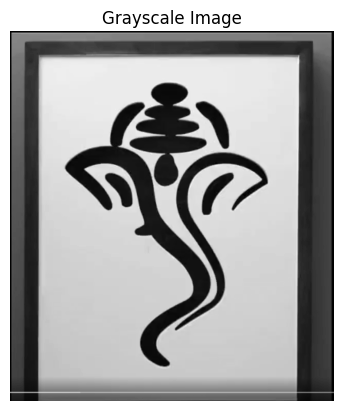

In [92]:
def rgb_to_grayscale(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    #grayscale=(r/3)+(g/3)+(b/3) 
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale / 255.0  # Normalize to [0, 1] range

gray_image = rgb_to_grayscale(image)

plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

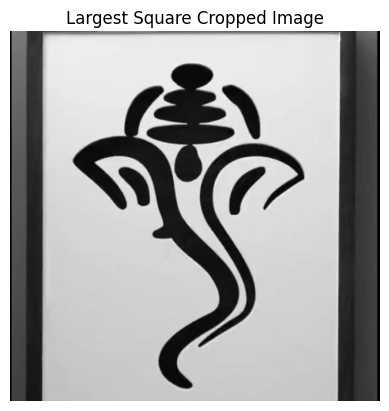

In [93]:
def largest_square(image):
    height, width = image.shape[:2]
    if height <= width:
        short_edge = height
        long_edge_half = width // 2
        short_edge_half = short_edge // 2
        return image[:, long_edge_half - short_edge_half : long_edge_half + short_edge_half]
    else:
        short_edge = width
        long_edge_half = height // 2
        short_edge_half = short_edge // 2
        return image[long_edge_half - short_edge_half : long_edge_half + short_edge_half, :]

square_image = largest_square(gray_image)

plt.imshow(square_image, cmap='gray')
plt.title("Largest Square Cropped Image")
plt.axis('off')
plt.show()

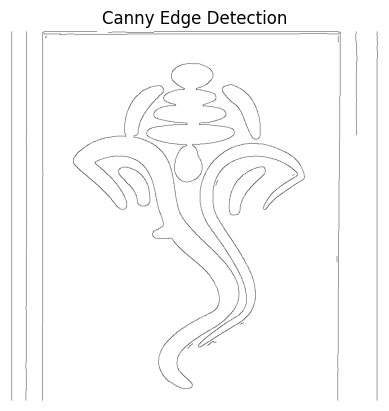

In [94]:
edges = feature.canny(square_image, sigma=1)

plt.imshow(1-edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()


In [95]:
edges.shape
#image.shape

(942, 943)

In [96]:
def create_circle_nail_positions_by_count(picture_shape, num_nails):
    height, width = picture_shape
    center_y, center_x = height // 2, width // 2
    radius = min(height, width) // 2 - 10

    nails = []
    for i in range(num_nails):
        theta = 2 * np.pi * i / num_nails
        y = int(center_y + radius * np.sin(theta))
        x = int(center_x + radius * np.cos(theta))
        nails.append((y, x))

    return nails


In [ ]:
def get_aa_line(from_pos, to_pos, str_strength, picture):
    # line_overlay = picture.copy() # Redundant line removed
    rr, cc, val = line_aa(from_pos[0], from_pos[1], to_pos[0], to_pos[1])
    line_overlay = picture.copy() # Keep this copy
    
    # Ensure rr, cc are within bounds before attempting to assign
    valid_mask = (rr >= 0) & (rr < line_overlay.shape[0]) & \
                 (cc >= 0) & (cc < line_overlay.shape[1])
    rr_valid, cc_valid, val_valid = rr[valid_mask], cc[valid_mask], val[valid_mask]
    
    line_overlay[rr_valid, cc_valid] = np.clip(line_overlay[rr_valid, cc_valid] - str_strength * val_valid, 0, 1)
    return line_overlay, rr_valid, cc_valid 

In [ ]:
def find_best_nail(curr_pos, curr_nail_idx, nails, str_pic, orig_pic, str_strength): # Added curr_nail_idx
    best_improvement = 0.0  
    best_nail_pos = None
    best_nail_idx = None

    for idx, nail in enumerate(nails):
        if idx == curr_nail_idx:  
            continue

        
        temp_str_pic_for_eval = str_pic.copy() 
        overlayed_line_pixels, rr, cc = get_aa_line(curr_pos, nail, str_strength, temp_str_pic_for_eval)

        if len(rr) == 0: 
              continue
        
        
        before_diff_sq = (str_pic[rr, cc] - orig_pic[rr, cc]) ** 2
        after_diff_sq = (overlayed_line_pixels[rr, cc] - orig_pic[rr, cc]) ** 2 

        improvement = np.sum(before_diff_sq - after_diff_sq)

        if improvement > best_improvement:
            best_improvement = improvement
            best_nail_pos = nail
            best_nail_idx = idx

    
    if best_nail_idx is None:
        return None, None, 0 
        
    return best_nail_idx, best_nail_pos, best_improvement

In [ ]:

def create_string_art(orig_pic, nails, num_iterations=2500, str_strength=0.5):
    str_art = np.ones_like(orig_pic)  
    curr_idx = 0  
    pull_order = [curr_idx]  

    print(f"Starting string art generation with str_strength: {str_strength}")
    
    
    last_completed_iteration = -1 

    for i in range(num_iterations):
        last_completed_iteration = i 
        curr_pos = nails[curr_idx]
        
        
        best_idx, best_pos, improvement = find_best_nail(
            curr_pos,
            curr_idx,      
            nails,
            str_art,
            orig_pic,
            str_strength=str_strength 
        )

        if best_idx is None: 
            print(f"Stopping at iteration {i+1}/{num_iterations}: No further positive improvement found.")
            break 


        
        str_art, _, _ = get_aa_line(curr_pos, best_pos, str_strength, str_art)

        pull_order.append(best_idx)
        curr_idx = best_idx
        
        if (i + 1) % 100 == 0:
            print(f"Iteration {i+1}/{num_iterations} completed. Last improvement: {improvement:.2f}")
    else: 
        if num_iterations > 0 :
             print(f"Completed all {num_iterations} iterations.")


    return str_art, pull_order

Target image min/max BEFORE rescaling: 0.5672, 1.0000
Target image min/max AFTER rescaling: 0.0000, 1.0000


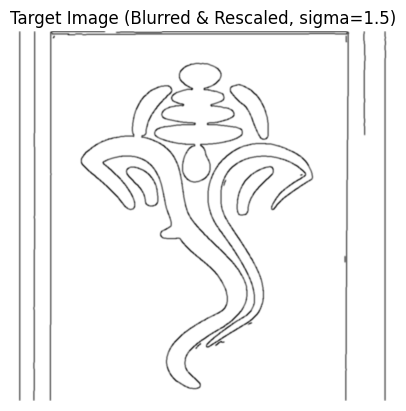

Starting string art generation with str_strength: 0.05
Iteration 100/5000 completed. Last improvement: 4.18
Iteration 200/5000 completed. Last improvement: 3.25
Iteration 300/5000 completed. Last improvement: 1.86
Iteration 400/5000 completed. Last improvement: 0.86
Stopping at iteration 493/5000: No further positive improvement found.


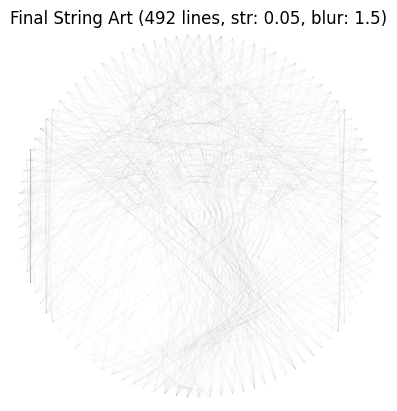

Number of lines drawn: 492
Final art min/max pixel values: 0.0000, 1.0000


In [ ]:

from skimage.filters import gaussian 

base_target = 1.0 - edges.astype(np.float32)


blur_sigma = 1.5 
blurred_target = gaussian(base_target, sigma=blur_sigma)


min_val = blurred_target.min()
max_val = blurred_target.max()

if max_val > min_val: 
    orig_pic_target = (blurred_target - min_val) / (max_val - min_val)
else:
    orig_pic_target = np.zeros_like(blurred_target) if min_val == 0 else np.ones_like(blurred_target) * blurred_target[0,0]


print(f"Target image min/max BEFORE rescaling: {min_val:.4f}, {max_val:.4f}")
print(f"Target image min/max AFTER rescaling: {orig_pic_target.min():.4f}, {orig_pic_target.max():.4f}") # Should be ~0.0 and ~1.0

plt.imshow(orig_pic_target, cmap='gray')
plt.title(f"Target Image (Blurred & Rescaled, sigma={blur_sigma})")
plt.axis('off')
plt.show()


num_nails_val = 100 
num_iterations_val = 5000 


str_strength_val = 0.05 

nails = create_circle_nail_positions_by_count(edges.shape, num_nails=num_nails_val)


final_art, pull_order = create_string_art(orig_pic_target, nails,
                                          num_iterations=num_iterations_val,
                                          str_strength=str_strength_val)

plt.imshow(final_art, cmap='gray')
plt.title(f"Final String Art ({len(pull_order)-1} lines, str: {str_strength_val}, blur: {blur_sigma})")
plt.axis('off')
plt.show()

print(f"Number of lines drawn: {len(pull_order) -1}")
print(f"Final art min/max pixel values: {final_art.min():.4f}, {final_art.max():.4f}")